In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
file_url = "http://storage.googleapis.com/download.tensorflow.org/data/heart.csv"
dataframe = pd.read_csv(file_url)

In [5]:
dataframe.shape

(303, 14)

In [6]:
dataframe.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [7]:
val_dataframe = dataframe.sample(frac=0.2, random_state=1337)

In [8]:
train_dataset = dataframe.drop(val_dataframe.index)

In [9]:
print("Using %d samples for training and %d for validation" 
      % (len(train_dataset), len(val_dataframe)))

Using 242 samples for training and 61 for validation


In [10]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("target")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


In [11]:
train_ds = dataframe_to_dataset(train_dataset)

In [12]:
val_ds = dataframe_to_dataset(val_dataframe)

In [13]:
train_ds

<ShuffleDataset shapes: ({age: (), sex: (), cp: (), trestbps: (), chol: (), fbs: (), restecg: (), thalach: (), exang: (), oldpeak: (), slope: (), ca: (), thal: ()}, ()), types: ({age: tf.int64, sex: tf.int64, cp: tf.int64, trestbps: tf.int64, chol: tf.int64, fbs: tf.int64, restecg: tf.int64, thalach: tf.int64, exang: tf.int64, oldpeak: tf.float64, slope: tf.int64, ca: tf.int64, thal: tf.string}, tf.int64)>

In [14]:
val_ds

<ShuffleDataset shapes: ({age: (), sex: (), cp: (), trestbps: (), chol: (), fbs: (), restecg: (), thalach: (), exang: (), oldpeak: (), slope: (), ca: (), thal: ()}, ()), types: ({age: tf.int64, sex: tf.int64, cp: tf.int64, trestbps: tf.int64, chol: tf.int64, fbs: tf.int64, restecg: tf.int64, thalach: tf.int64, exang: tf.int64, oldpeak: tf.float64, slope: tf.int64, ca: tf.int64, thal: tf.string}, tf.int64)>

In [15]:
for x,y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)

Input: {'age': <tf.Tensor: shape=(), dtype=int64, numpy=46>, 'sex': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'cp': <tf.Tensor: shape=(), dtype=int64, numpy=2>, 'trestbps': <tf.Tensor: shape=(), dtype=int64, numpy=101>, 'chol': <tf.Tensor: shape=(), dtype=int64, numpy=197>, 'fbs': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'restecg': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'thalach': <tf.Tensor: shape=(), dtype=int64, numpy=156>, 'exang': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'oldpeak': <tf.Tensor: shape=(), dtype=float64, numpy=0.0>, 'slope': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'ca': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'thal': <tf.Tensor: shape=(), dtype=string, numpy=b'reversible'>}
Target: tf.Tensor(0, shape=(), dtype=int64)


In [16]:
train_ds = train_ds.batch(32)
train_ds

<BatchDataset shapes: ({age: (None,), sex: (None,), cp: (None,), trestbps: (None,), chol: (None,), fbs: (None,), restecg: (None,), thalach: (None,), exang: (None,), oldpeak: (None,), slope: (None,), ca: (None,), thal: (None,)}, (None,)), types: ({age: tf.int64, sex: tf.int64, cp: tf.int64, trestbps: tf.int64, chol: tf.int64, fbs: tf.int64, restecg: tf.int64, thalach: tf.int64, exang: tf.int64, oldpeak: tf.float64, slope: tf.int64, ca: tf.int64, thal: tf.string}, tf.int64)>

In [17]:
val_ds = val_ds.batch(32)
val_ds

<BatchDataset shapes: ({age: (None,), sex: (None,), cp: (None,), trestbps: (None,), chol: (None,), fbs: (None,), restecg: (None,), thalach: (None,), exang: (None,), oldpeak: (None,), slope: (None,), ca: (None,), thal: (None,)}, (None,)), types: ({age: tf.int64, sex: tf.int64, cp: tf.int64, trestbps: tf.int64, chol: tf.int64, fbs: tf.int64, restecg: tf.int64, thalach: tf.int64, exang: tf.int64, oldpeak: tf.float64, slope: tf.int64, ca: tf.int64, thal: tf.string}, tf.int64)>

In [18]:
from tensorflow.keras.layers.experimental.preprocessing import IntegerLookup
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.layers.experimental.preprocessing import StringLookup

In [19]:
def encode_numerical_feature(feature, name, dataset):
    normalizer = Normalization()
    feature_ds = dataset.map(lambda x,y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))
    normalizer.adapt(feature_ds)
    encoded_feature = normalizer(feature)
    return encoded_feature

In [20]:
def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    lookup = lookup_class(output_mode="binary")
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))
    lookup.adapt(feature_ds)
    encoded_feature = lookup(feature)
    return encoded_feature

In [21]:
sex = keras.Input(shape=(1,), name="sex", dtype="int64")
cp = keras.Input(shape=(1,), name="cp", dtype="int64")
fbs = keras.Input(shape=(1,), name="fbs", dtype="int64")
restecg = keras.Input(shape=(1,), name="restecg", dtype="int64")
exang = keras.Input(shape=(1,), name="exang", dtype="int64")
ca = keras.Input(shape=(1,), name="ca", dtype="int64")

thal = keras.Input(shape=(1,), name="thal", dtype="string")

age = keras.Input(shape=(1,), name="age")
trestbps = keras.Input(shape=(1,), name="trestbps")
chol = keras.Input(shape=(1,), name="chol")
thalach = keras.Input(shape=(1,), name="thalach")
oldpeak = keras.Input(shape=(1,), name="oldpeak")
slope = keras.Input(shape=(1,), name="slope")

In [22]:
all_inputs = [
    sex,
    cp,
    fbs,
    restecg,
    exang,
    ca,
    thal,
    age,
    trestbps,
    chol,
    thalach,
    oldpeak,
    slope,
]

In [30]:
all_inputs

[<KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'sex')>,
 <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'cp')>,
 <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'fbs')>,
 <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'restecg')>,
 <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'exang')>,
 <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'ca')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'thal')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'age')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'trestbps')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'chol')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'thalach')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'oldpeak')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'slope')>]

In [39]:
sex_encoded = encode_categorical_feature(sex, "sex", train_ds, False)
sex_encoded

<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'integer_lookup_12')>

In [32]:
cp_encoded = encode_categorical_feature(cp, "cp", train_ds, False)
fbs_encoded = encode_categorical_feature(fbs, "fbs", train_ds, False)
restecg_encoded = encode_categorical_feature(restecg, "restecg", train_ds, False)
exang_encoded = encode_categorical_feature(exang, "exang", train_ds, False)
ca_encoded = encode_categorical_feature(ca, "ca", train_ds, False)

In [40]:
# String categorical features
thal_encoded = encode_categorical_feature(thal, "thal", train_ds, True)
thal_encoded

<KerasTensor: shape=(None, 6) dtype=float32 (created by layer 'string_lookup_2')>

In [34]:
# Numerical features
age_encoded = encode_numerical_feature(age, "age", train_ds)
trestbps_encoded = encode_numerical_feature(trestbps, "trestbps", train_ds)
chol_encoded = encode_numerical_feature(chol, "chol", train_ds)
thalach_encoded = encode_numerical_feature(thalach, "thalach", train_ds)
oldpeak_encoded = encode_numerical_feature(oldpeak, "oldpeak", train_ds)
slope_encoded = encode_numerical_feature(slope, "slope", train_ds)

In [35]:
all_features = layers.concatenate(
    [
        sex_encoded,
        cp_encoded,
        fbs_encoded,
        restecg_encoded,
        exang_encoded,
        slope_encoded,
        ca_encoded,
        thal_encoded,
        age_encoded,
        trestbps_encoded,
        chol_encoded,
        thalach_encoded,
        oldpeak_encoded,
    ]
)

In [36]:
all_features

<KerasTensor: shape=(None, 30) dtype=float32 (created by layer 'concatenate_1')>

In [37]:
x = layers.Dense(32, activation="relu")(all_features)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(all_inputs, output)
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

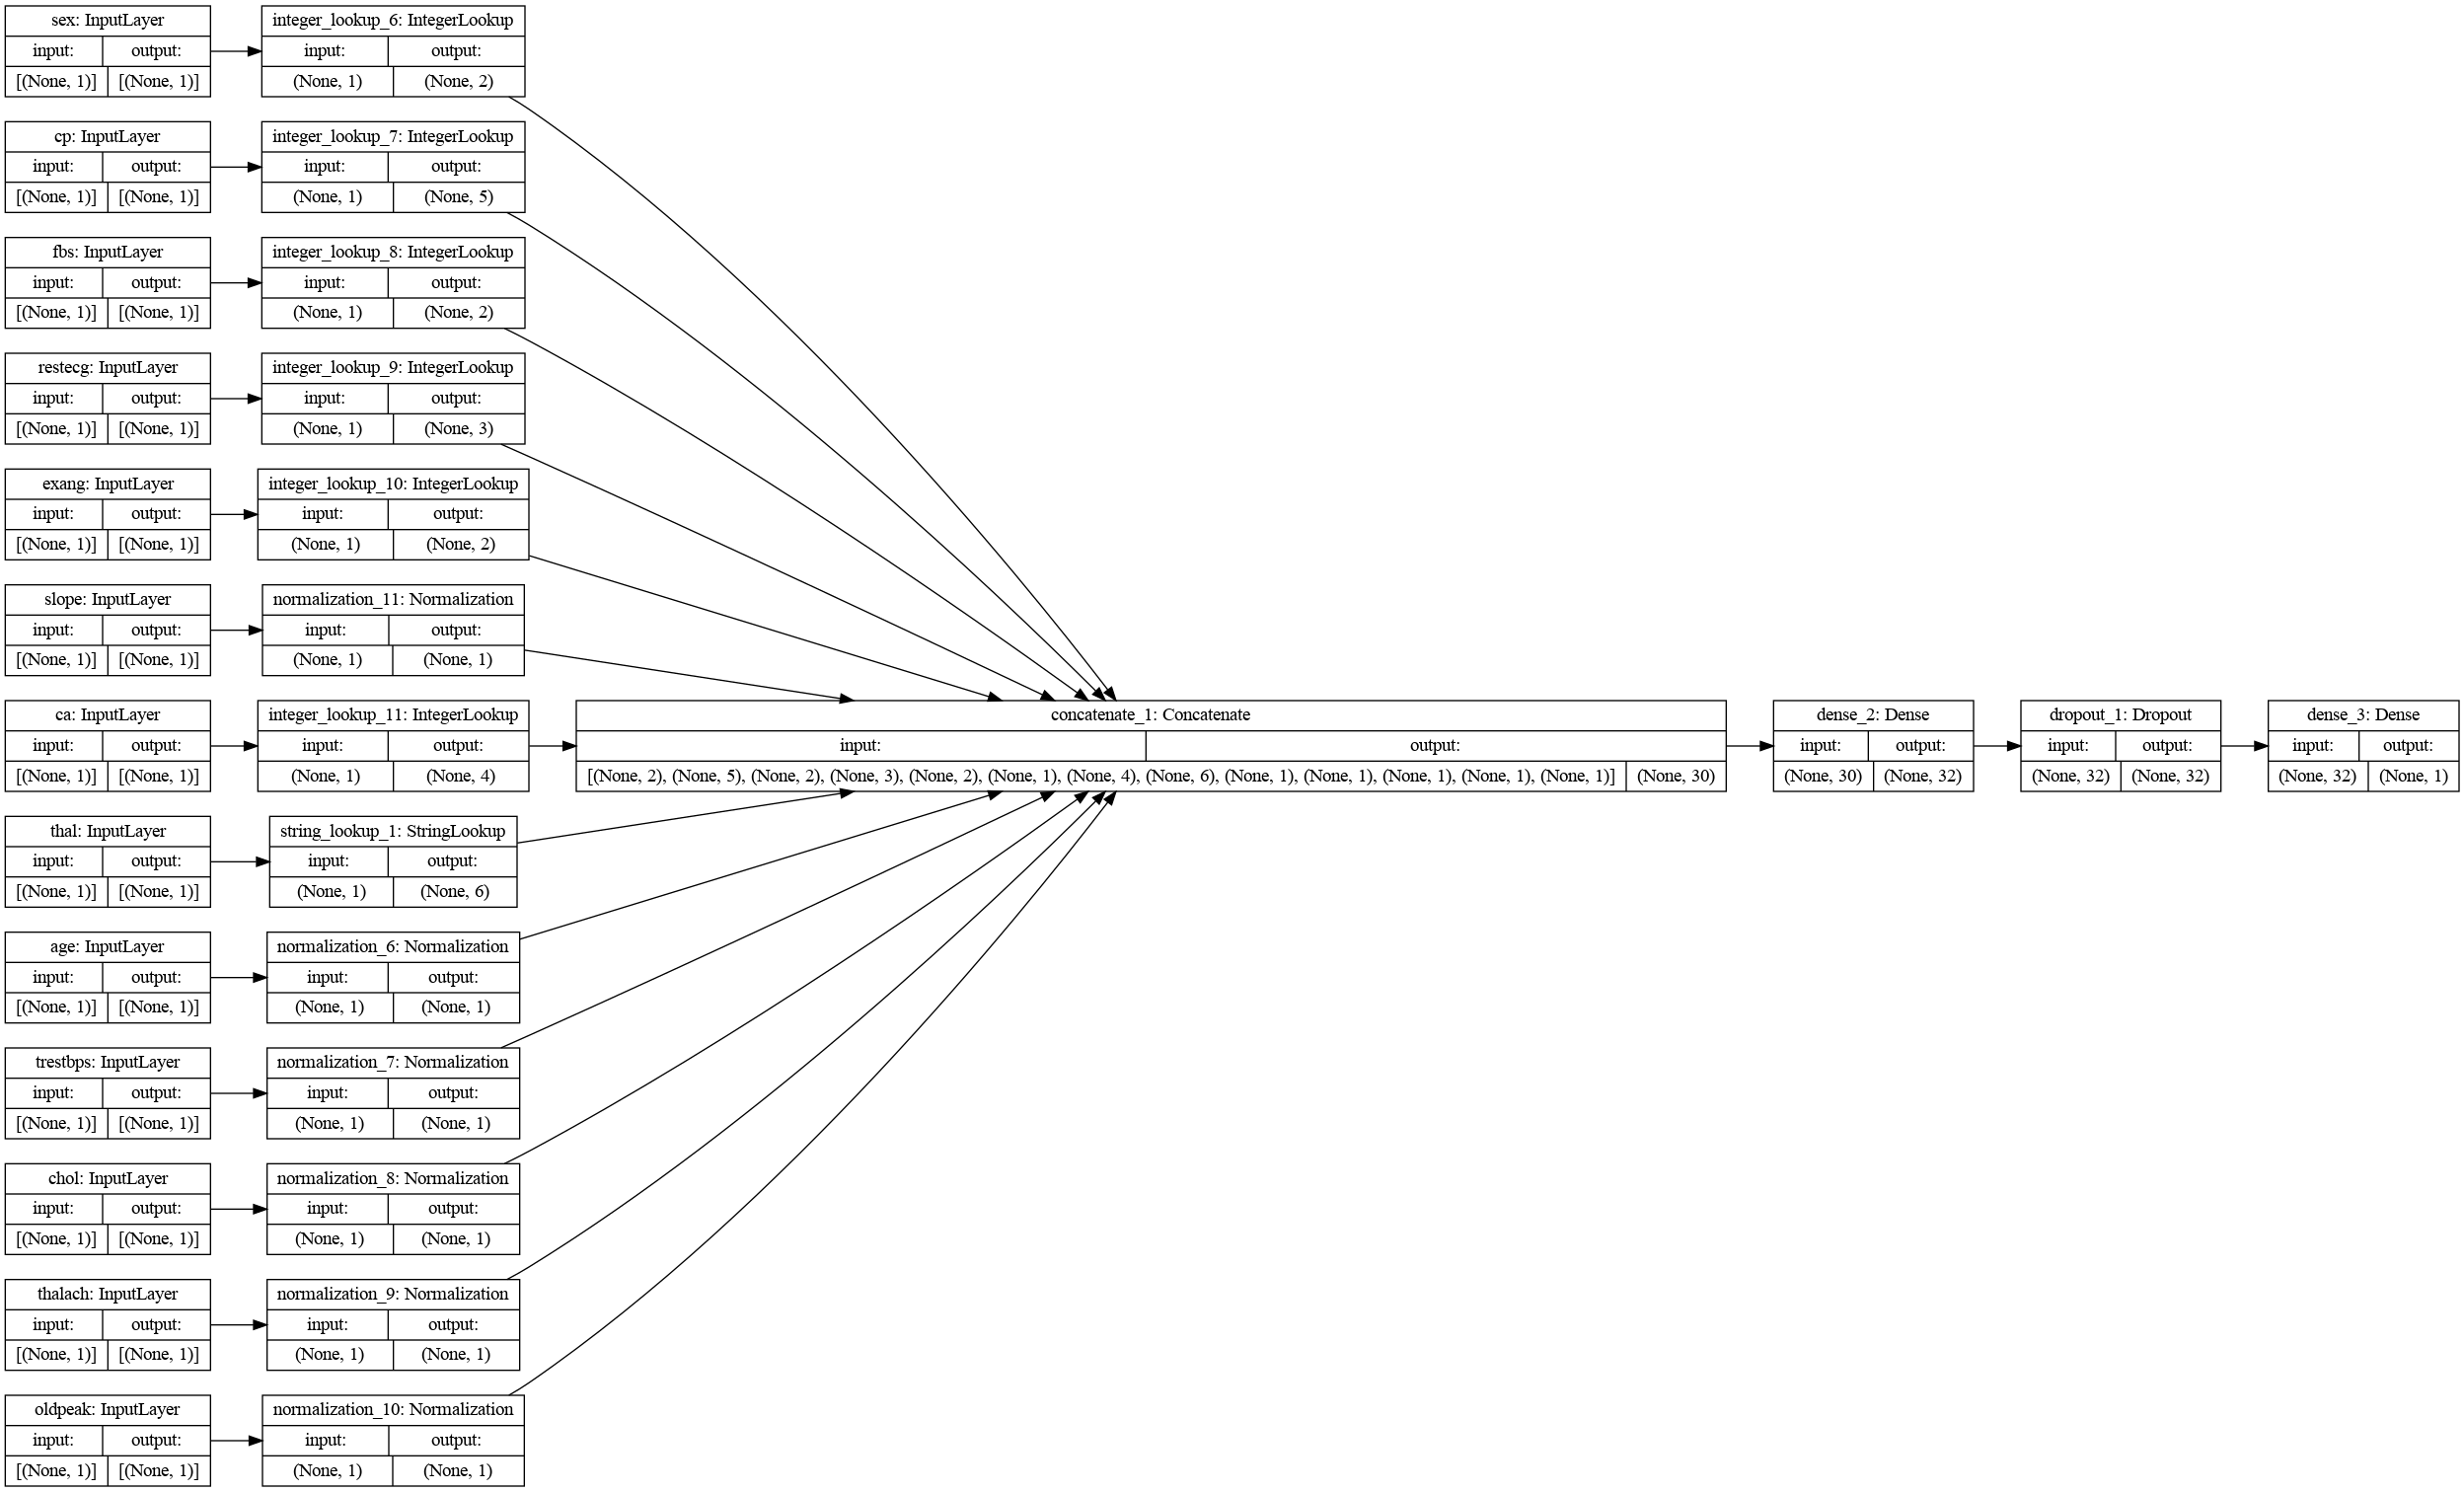

In [38]:
# `rankdir='LR'` is to make the graph horizontal.
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [29]:
model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
8/8 [==============================] - 1s 40ms/step - loss: 0.7585 - accuracy: 0.4711 - val_loss: 0.7196 - val_accuracy: 0.4918
Epoch 2/50
8/8 [==============================] - 0s 4ms/step - loss: 0.6623 - accuracy: 0.6074 - val_loss: 0.6721 - val_accuracy: 0.5738
Epoch 3/50
8/8 [==============================] - 0s 4ms/step - loss: 0.6762 - accuracy: 0.5744 - val_loss: 0.6339 - val_accuracy: 0.6230
Epoch 4/50
8/8 [==============================] - 0s 5ms/step - loss: 0.6398 - accuracy: 0.6529 - val_loss: 0.5996 - val_accuracy: 0.7869
Epoch 5/50
8/8 [==============================] - 0s 5ms/step - loss: 0.5871 - accuracy: 0.7066 - val_loss: 0.5725 - val_accuracy: 0.7705
Epoch 6/50
8/8 [==============================] - 0s 5ms/step - loss: 0.5977 - accuracy: 0.6612 - val_loss: 0.5483 - val_accuracy: 0.7541
Epoch 7/50
8/8 [==============================] - 0s 4ms/step - loss: 0.5452 - accuracy: 0.7314 - val_loss: 0.5288 - val_accuracy: 0.7705
Epoch 8/50
8/8 [=================

In [42]:
sample = {
    "age": 60,
    "sex": 1,
    "cp": 1,
    "trestbps": 145,
    "chol": 233,
    "fbs": 1,
    "restecg": 2,
    "thalach": 150,
    "exang": 0,
    "oldpeak": 2.3,
    "slope": 3,
    "ca": 0,
    "thal": "fixed",
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
input_dict

{'age': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([60], dtype=int32)>,
 'sex': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'cp': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'trestbps': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([145], dtype=int32)>,
 'chol': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([233], dtype=int32)>,
 'fbs': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'restecg': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([2], dtype=int32)>,
 'thalach': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([150], dtype=int32)>,
 'exang': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>,
 'oldpeak': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.3], dtype=float32)>,
 'slope': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([3], dtype=int32)>,
 'ca': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>,
 'thal': <tf.Tensor: shape=(1,), dtype=stri

In [43]:
predictions = model.predict(input_dict)
predictions

array([[0.493734]], dtype=float32)

In [44]:
print(
    "This particular patient had a %.1f percent probability "
    "of having a heart disease, as evaluated by our model." % (100 * predictions[0][0],)
)

This particular patient had a 49.4 percent probability of having a heart disease, as evaluated by our model.
